In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import scipy.stats.distributions as dist

In [2]:
CNN_csv = 'CNN_info_V3.parquet'
CNN_dir = '/home/AstroPhysics-Shared/PROJECTS/MPhys_Villforth/DATA/CNN_dir/'
real_dir = '/home/AstroPhysics-Shared/PROJECTS/MPhys_Villforth/DATA/IMG_dir/REAL_FITS_11_04v2_dir/'
df_dir = '/home/AstroPhysics-Shared/PROJECTS/MPhys_Villforth/DATA/DF_dir/'
objects_df = pd.read_parquet(df_dir + 'objects_master_22_10_28.parquet')

cnn_run_table = pd.read_parquet(CNN_dir + CNN_csv)

cnn_run_table

,RUN_ID,N-EPOCHS,PIX_SCALE,TH_OPT,TH_OPT_F1,TRA_ACC,VAL_ACC,TRA_LOSS,VAL_LOSS,TEST_SIZE_TRN,TEST_SIZE_VAL,N-PICTURES,ratio_merger,dt_merger,ratio_nonmerger,dt_nonmerger,snap_lower,snap upper,gal_params
0,12,50,50,0.485485,0.380380,0.815517,0.787911,0.412621,0.434683,0.2,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,13,50,50,0.553554,0.437437,0.831034,0.820785,0.364593,0.377537,0.2,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
def pull_results(run_id):

    CNN_dir = '/home/AstroPhysics-Shared/PROJECTS/MPhys_Villforth/DATA/CNN_dir/CNN_run_%05d/' %(run_id)
    subhalos_csv = 'CNN_run_%05d_subhalo_labels.csv' %(run_id)
    CNN_csv = 'CNN_run_%05d_info.csv' %(run_id)
    results = pd.read_csv(CNN_dir + subhalos_csv)
    out = []
    for idx, row in results.iterrows():
        
        halo = objects_df.loc[(objects_df['SFID'] == row.SFID) & (objects_df['SnapNum'] == row.SNAP)]
        out.append(halo.values.flatten().tolist())
        gas_frac = (halo['Mgas'].values/halo['Mstellar'].values).flatten()[0]
        
        if gas_frac == float('-inf'):
            gas_frac = 0
            
        out[-1].extend([gas_frac, row.PRED_LABEL, row.LABEL])

    cols = objects_df.columns.values.tolist()
    cols.extend(['GAS_FRAC', 'PRED_LABEL', 'LABEL'])
    results = pd.DataFrame(out,columns = cols)
    
    return results
    

In [4]:
results = pull_results(14)
results_14 = results
results_4 = pull_results(4)
results_15 = pull_results(15)

In [5]:
def separate_results(results):
    # Find true positives, false positives, true negatives, false negatives
    TP = results.loc[(results['LABEL'] == 1) & (results['PRED_LABEL'] > 0.5)]
    FP = results.loc[(results['LABEL'] == 0) & (results['PRED_LABEL'] > 0.5)]
    TN = results.loc[(results['LABEL'] == 0) & (results['PRED_LABEL'] < 0.5)]
    FN = results.loc[(results['LABEL'] == 1) & (results['PRED_LABEL'] < 0.5)]
    true = results.loc[((results['LABEL'] == 1) & (results['PRED_LABEL'] > 0.5)) | ((results['LABEL'] == 0) & (results['PRED_LABEL'] < 0.5))]
    false = results.loc[((results['LABEL'] == 0) & (results['PRED_LABEL'] > 0.5)) | ((results['LABEL'] == 1) & (results['PRED_LABEL'] < 0.5))]
    TP = TP.reset_index(drop=True)
    FP = FP.reset_index(drop=True)
    TN = TN.reset_index(drop=True)
    FN = FN.reset_index(drop=True)
    true = true.reset_index(drop=True)
    false = false.reset_index(drop=True)
    
    return TP, FP, TN, FN, true, false

In [6]:
TP, FP, TN, FN, true, false = separate_results(results_14)

In [7]:
dfs = {0:TP, 1:FP, 2:TN, 3:FN}

309
242
118
23
316
288
115
9
27
20
20
3
32
21
12
9
26
24
19
1
15
7
23
22
12
8
7
2
7
6
12
10


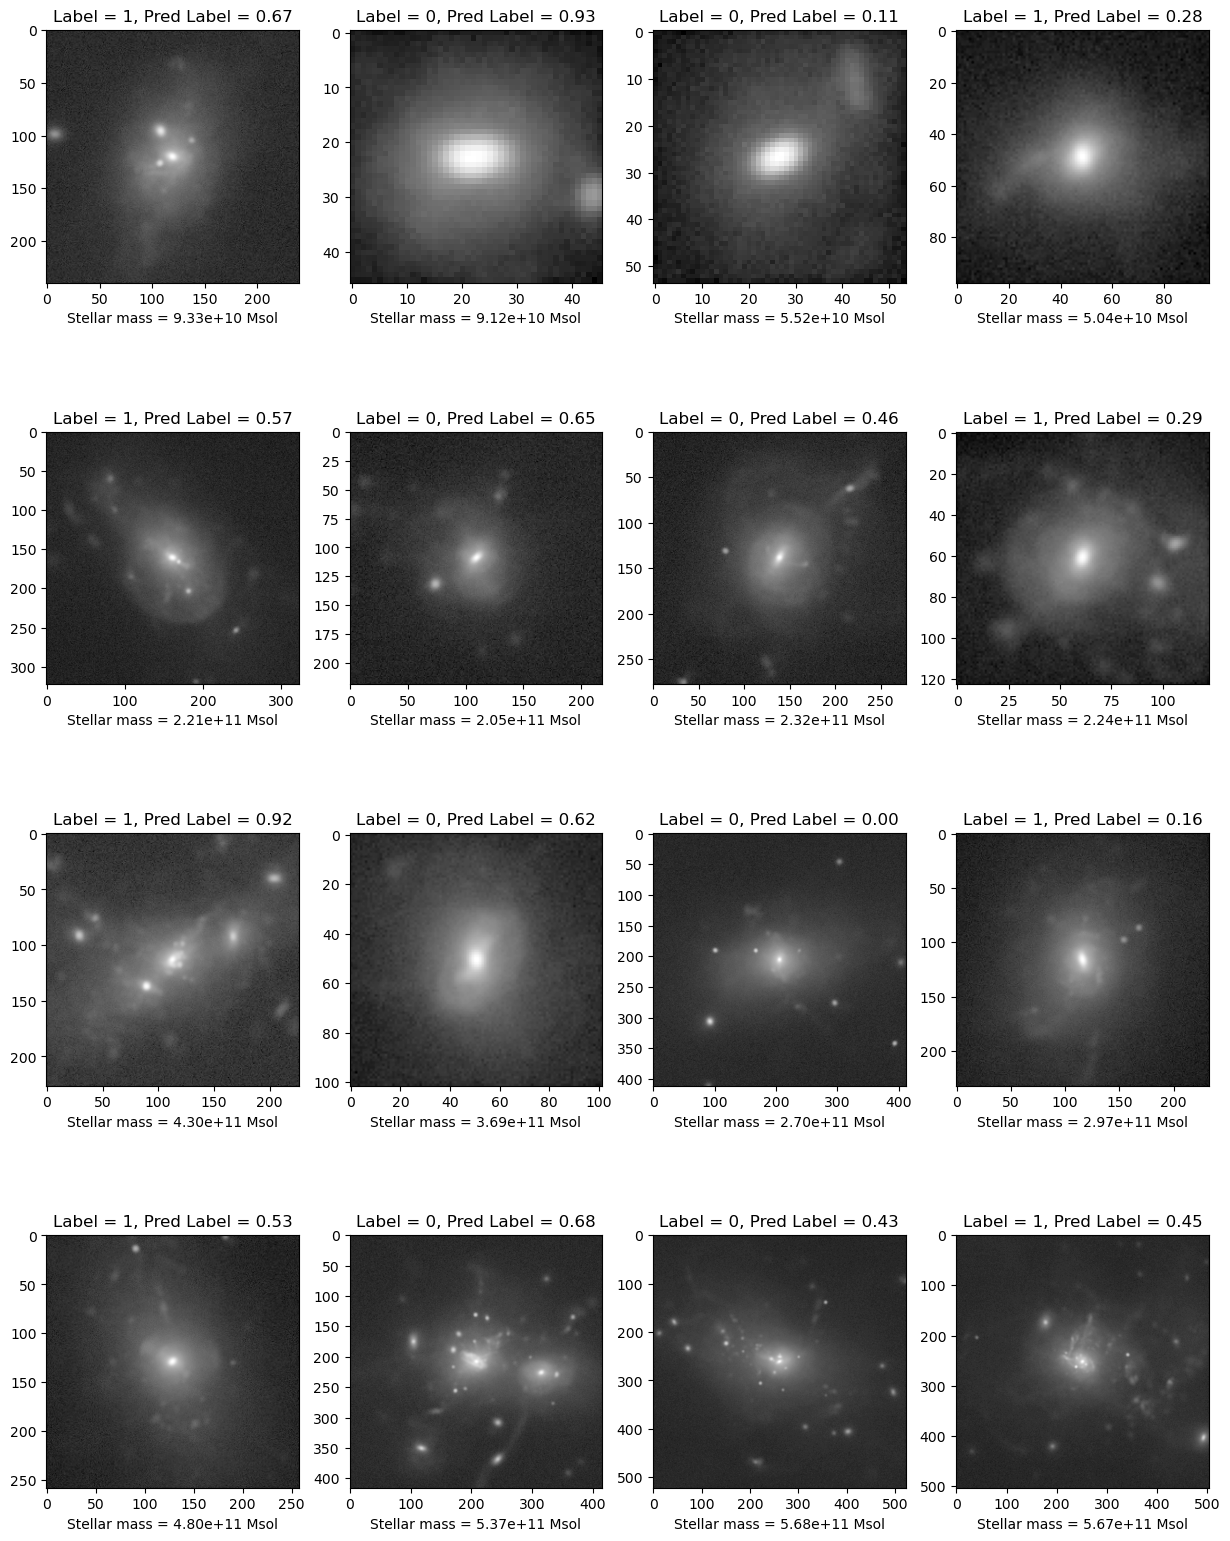

In [12]:
# Plot a few example galaxies from each population

dfs = [TP, FP, TN, FN]

mass_lims_list = [[5, 10], [20, 25], [25, 45], [45, 75]]

fig = plt.figure(figsize = (15,5 * len(mass_lims_list)))
ax = fig.subplots(4,4)

for j, mass_lims in enumerate(mass_lims_list):

    for i, df in enumerate(dfs):
        df_filt = df.loc[(df['Mstellar'] > mass_lims[0]) & (df['Mstellar'] < mass_lims[1])].reset_index(drop = True)
        print(len(df_filt))
        if (len(df_filt) > 0):
            idx = np.random.randint(0, len(df_filt))
            print(idx)
            hdul = fits.open(real_dir + 'SFID_%07d_SNAP_%02d.fits' %(df_filt['SFID'][idx], df_filt['SnapNum'][idx]))
            ax[j,i].imshow(hdul[1].data[0], cmap = 'gray_r')
            ax[j,i].set_title('Label = %01d, Pred Label = %.02f' %(df_filt['LABEL'][idx], df_filt['PRED_LABEL'][idx]))
            ax[j,i].set_xlabel('Stellar mass = %.2e'%(df_filt['Mstellar'][idx] * 1e10) + ' Msol')

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

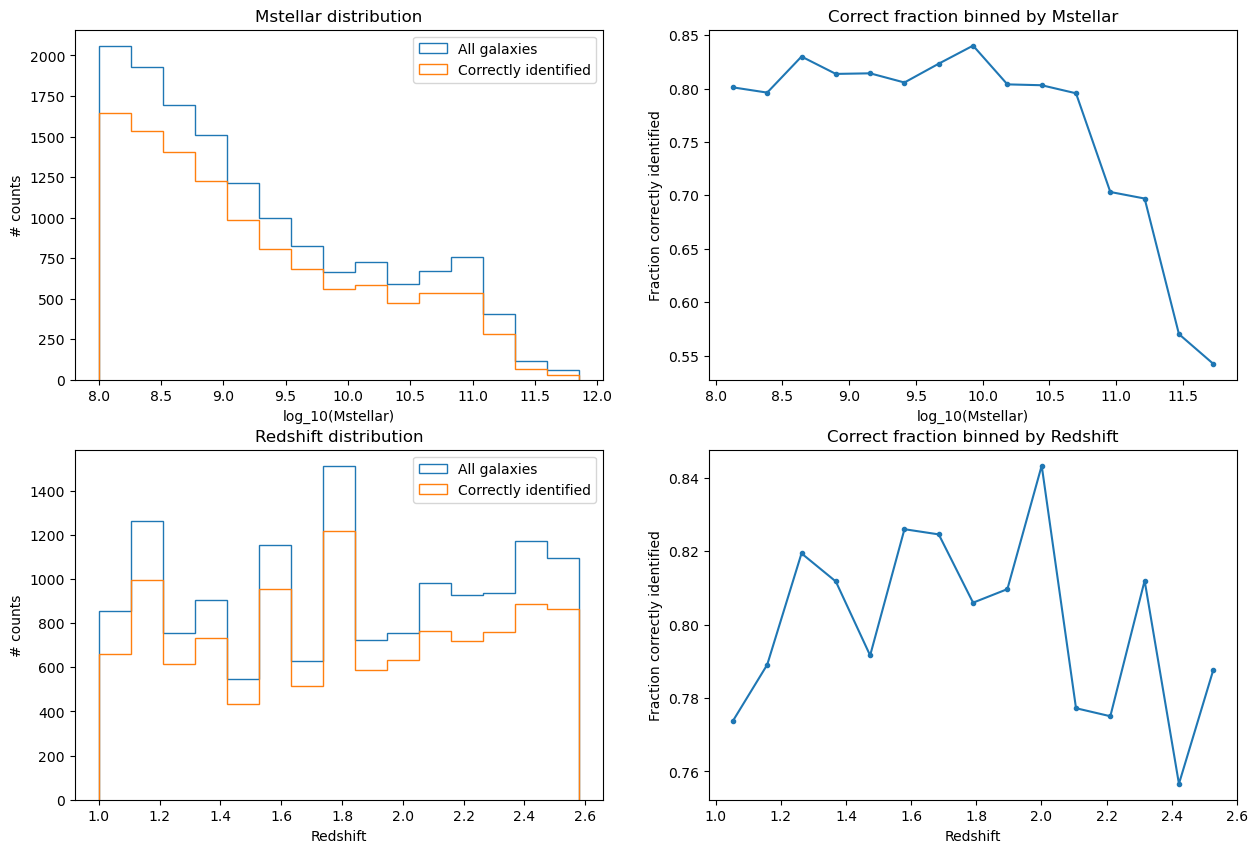

In [10]:
params = ['Mstellar', 'Redshift']
no_log = ['Redshift', 'ratio_recent', 'MBH', 'Mgas', 'SFR', 'Z', 'BHacc', 'ratio_recent', 'dt_recent', 'ratio_biggest', 'dt_biggest']

fig = plt.figure(figsize = (15,5 * len(params)))
ax = fig.subplots(len(params),2)

for i in range(len(params)):
    
    if params[i] in no_log:
        counts_total, edges, bars = ax[i,0].hist(results[params[i]].values, bins = 15, histtype = 'step', label = 'All galaxies')
        counts, edges, bars = ax[i,0].hist(true[params[i]].values, bins = edges, histtype = 'step', label = 'Correctly identified')
    
    else:
        counts_total, edges, bars = ax[i,0].hist(np.log10(results[params[i]].values * 1e10), bins = 15, histtype = 'step', label = 'All galaxies')
        counts, edges, bars = ax[i,0].hist(np.log10(true[params[i]].values * 1e10), bins = edges, histtype = 'step', label = 'Correctly identified')
    
    centers = 0.5*(edges[1:]+ edges[:-1])
    ax[i,1].plot(centers, counts/counts_total, '.-')
    ax[i,1].set_ylabel('Fraction correctly identified')
    ax[i,1].set_title('Correct fraction binned by ' + params[i])
    
    ax[i,0].set_title(params[i] + ' distribution')
    ax[i,0].set_ylabel('# counts')
    ax[i,0].legend()
ax[0,0].set_xlabel('log_10(Mstellar)')
ax[0,1].set_xlabel('log_10(Mstellar)')

ax[1,0].set_xlabel('Redshift')
ax[1,1].set_xlabel('Redshift')
    
    
#plt.hist(np.log10(false.Mstellar.values), histtype = 'step', density = True)
plt.tight_layout

/opt/anaconda3/envs/astroconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

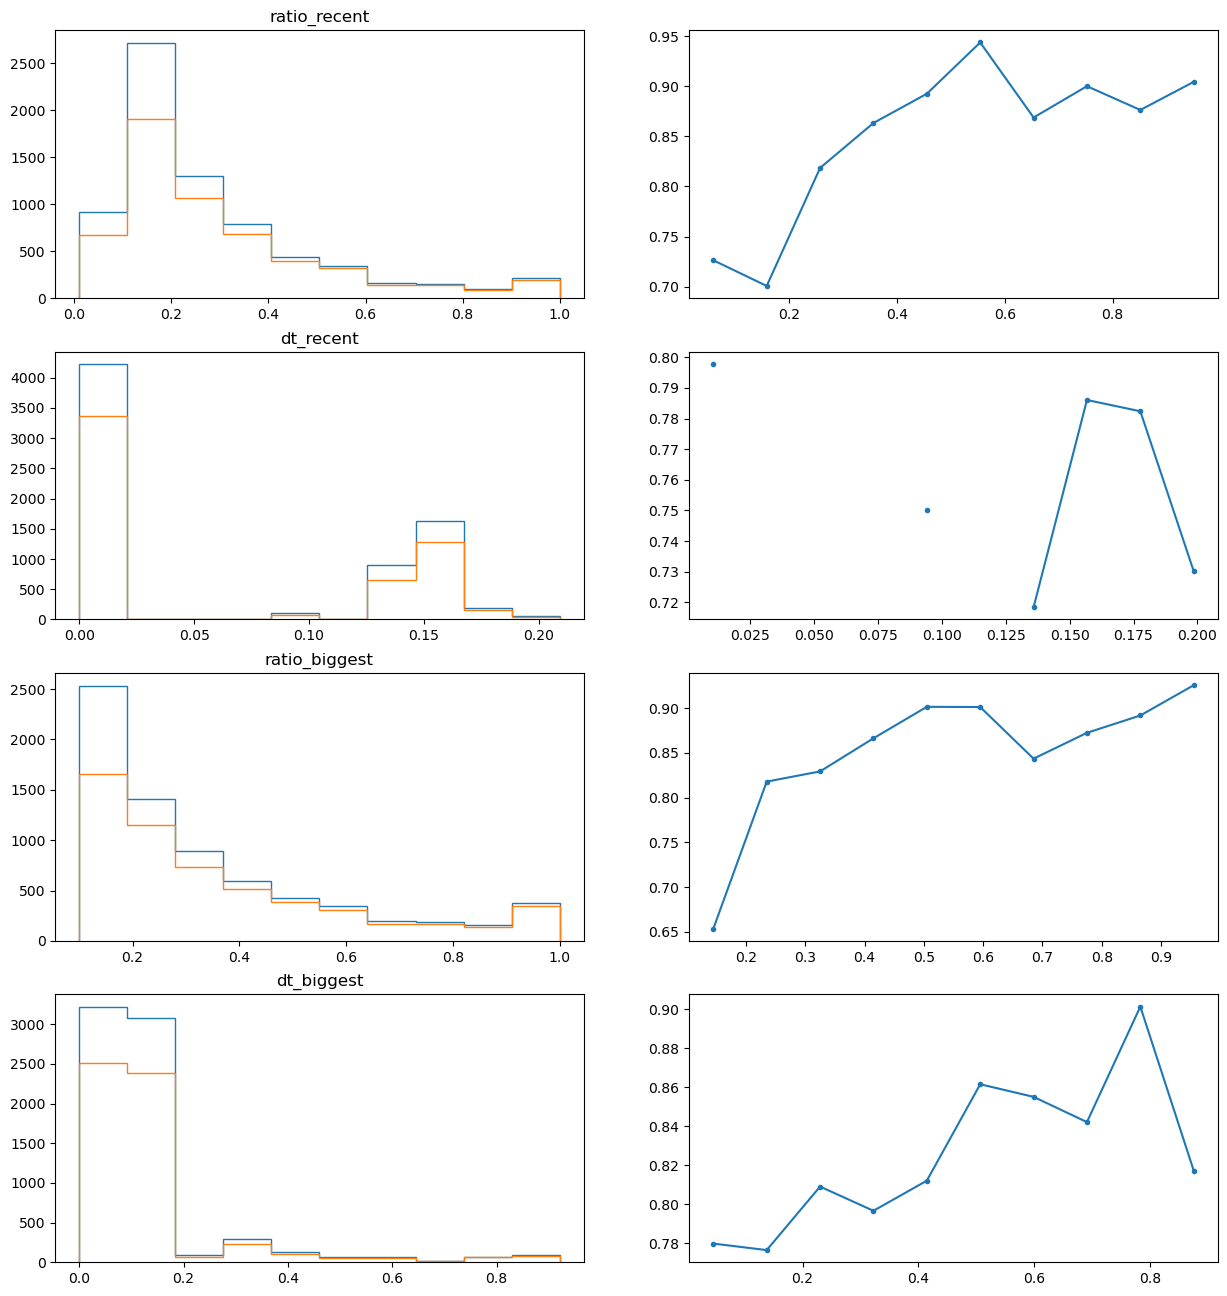

In [11]:
params = ['ratio_recent', 'dt_recent', 'ratio_biggest', 'dt_biggest']


fig = plt.figure(figsize = (15,4 * len(params)))
ax = fig.subplots(len(params),2)

for i in range(len(params)):
    
    if params[i] in no_log:
        counts_total, edges, bars = ax[i,0].hist(results.loc[results['LABEL'] == 1][params[i]].values, bins = 10, histtype = 'step')
        counts, edges, bars = ax[i,0].hist(true.loc[true['LABEL'] == 1][params[i]].values, bins = 10, histtype = 'step')
    
    else:
        counts_total, edges, bars = ax[i,0].hist(np.log10(results[params[i]].values), bins = 15, histtype = 'step')
        counts, edges, bars = ax[i,0].hist(np.log10(true[params[i]].values), bins = 15, histtype = 'step')
    
    centers = 0.5*(edges[1:]+ edges[:-1])
    ax[i,1].plot(centers, counts/counts_total, '.-')    
    ax[i,0].set_title(params[i])
    
    
#plt.hist(np.log10(false.Mstellar.values), histtype = 'step', density = True)
plt.tight_layout

In [33]:
params = ['Mstellar', 'Redshift', 'MBH', 'MDM', 'Mgas', 'SFR', 'Z',
       'HMRad', 'BHacc', 'GAS_FRAC']
no_log = ['Redshift', 'ratio_recent', 'HMRad', 'Z', 'ratio_recent', 'dt_recent', 'ratio_biggest', 'dt_biggest','GAS_FRAC']

scale = {'Mstellar': 1e10, 'MDM': 1e10, 'Mgas': 1e10, 'HMRad': 1, 'MBH': 1e10, 'BHacc' : 1e10, 'SFR' : 1}

def plot_split_results(results, TP, TN, params, no_log):
    
    
    

    fig = plt.figure(figsize = (15,6 * len(params)))
    ax = fig.subplots(len(params),2)
    
    probs = []

    for i in range(len(params)):
         
        error_bars = []

        if params[i] in no_log:
            counts_M_total, edges_M, bars = ax[i,0].hist(results.loc[results['LABEL'] == 1][params[i]].values, bins = 15, histtype = 'step', label = 'Post Mergers')
            counts_M, edges, bars = ax[i,0].hist(TP[params[i]].values, bins = edges_M, histtype = 'step', label = 'TP')
            counts_NM_total, edges_NM, bars = ax[i,0].hist(results.loc[results['LABEL'] == 0][params[i]].values, bins = edges_M, histtype = 'step', label = 'Controls')
            counts_NM, edges, bars = ax[i,0].hist(TN[params[i]].values, bins = edges_M, histtype = 'step', label = 'TN')

        else:
            # Create variable with log(results) and set -inf = 0
            
            results_M_total = np.log10(results.loc[results['LABEL'] == 1][params[i]].values * scale[params[i]])
            results_M = np.log10(TP[params[i]].values * 1e10)
            results_NM_total = np.log10(results.loc[results['LABEL'] == 0][params[i]].values * scale[params[i]])
            results_NM = np.log10(results.loc[(results['LABEL'] == 0) & (results['PRED_LABEL'] < 0.5)][params[i]].values * scale[params[i]])
            
            results_M_total[results_M_total == -np.inf] = 0
            results_M[results_M == -np.inf] = 0
            results_NM_total[results_NM_total == -np.inf] = 0
            results_NM[results_NM == -np.inf] = 0
            
            counts_M_total, edges_M, bars = ax[i,0].hist(results_M_total, bins = 15, histtype = 'step', label = 'Post Mergers')
            counts_M, edges, bars = ax[i,0].hist(results_M, bins = edges_M, histtype = 'step', label = 'TP')
            counts_NM_total, edges_NM, bars = ax[i,0].hist(results_NM_total, bins = edges_M, histtype = 'step', label = 'Controls')
            counts_NM, edges, bars = ax[i,0].hist(results_NM, bins = edges_M, histtype = 'step', label = 'TN')
            
            #counts_M_total, edges_M, bars = ax[i,0].hist(np.log10(results.loc[results['LABEL'] == 1][params[i]].values * 1e10), bins = 15, histtype = 'step', label = 'Post Mergers')
            #counts_M, edges, bars = ax[i,0].hist(np.log10(TP[params[i]].values * 1e10), bins = edges_M, histtype = 'step', label = 'TP')
            #counts_NM_total, edges_NM, bars = ax[i,0].hist(np.log10(results.loc[results['LABEL'] == 0][params[i]].values * 1e10), bins = 15, histtype = 'step', label = 'Controls')
            #counts_NM, edges, bars = ax[i,0].hist(np.log10(results.loc[(results['LABEL'] == 0) & (results['PRED_LABEL'] < 0.5)][params[i]].values * 1e10), bins = edges_NM, histtype = 'step', label = 'TN')
        
        if params[i] not in no_log:
            edges_M = 10**(edges_M-10)
            
        c = 0.683
        k_M, k_NM = counts_M, counts_NM
        n_M, n_NM = counts_M_total, counts_NM_total
        p_M_lower, p_NM_lower = dist.beta.ppf((1-c)/2.,k_M+1,n_M-k_M+1), dist.beta.ppf((1-c)/2.,k_NM+1,n_NM-k_NM+1)
        p_M_upper, p_NM_upper = dist.beta.ppf(1-(1-c)/2.,k_M+1,n_M-k_M+1), dist.beta.ppf(1-(1-c)/2.,k_NM+1,n_NM-k_NM+1)
        
        
        
        probs_M_total = []
        probs_M = []
        probs_NM_total = []
        probs_NM = []
        bin_edges = []
        
        for j in range(len(edges_M) - 1):
            probs_M_total.append(results.loc[(results['LABEL'] == 1) & (results[params[i]] > edges_M[j]) & (results[params[i]] < edges_M[j + 1])]['PRED_LABEL'].values)
            probs_M.append(TP.loc[(results[params[i]] > edges_M[j]) & (results[params[i]] < edges_M[j + 1])]['PRED_LABEL'].values)
            probs_NM_total.append(results.loc[(results['LABEL'] == 0) & (results[params[i]] > edges_M[j]) & (results[params[i]] < edges_M[j + 1])]['PRED_LABEL'].values)
            probs_NM.append(TN.loc[(results[params[i]] > edges_M[j]) & (results[params[i]] < edges_M[j + 1])]['PRED_LABEL'].values)
            bin_edges.append(np.array([edges_M[j], edges_M[j + 1]]))
            
        
        probs.append([probs_M_total, probs_M, probs_NM_total, probs_NM, bin_edges])
        

        centers = 0.5*(edges[1:]+ edges[:-1])
        yerr = np.absolute(np.array([p_M_lower - counts_M/counts_M_total, p_M_upper - counts_M/counts_M_total]))
        
        ax[i,1].errorbar(centers, counts_M/counts_M_total, yerr = yerr, fmt = '.-', label = 'PM')
        
        yerr = np.absolute(np.array([p_NM_lower - counts_NM/counts_NM_total, p_NM_upper - counts_NM/counts_NM_total]))
        
        ax[i,1].errorbar(centers, counts_NM/counts_NM_total, yerr = yerr , fmt = '.-', label = 'Controls')
        ax[i,1].set_ylabel('Fraction correctly identified')
        ax[i,1].set_title('Correct fraction binned by ' + params[i])
        ax[i,1].set_ylim(0, 1.05)
        ax[i,1].legend()
        
        
        ax[i,0].set_title(params[i] + ' distribution')
        ax[i,0].set_ylabel('# counts')
        ax[i,0].legend()
        
    ax[0,0].set_xlabel('log_10(Mstellar)')
    ax[0,1].set_xlabel('log_10(Mstellar)')

    ax[1,0].set_xlabel('Redshift')
    ax[1,1].set_xlabel('Redshift')

    
    #plt.hist(np.log10(false.Mstellar.values), histtype = 'step', density = True)
    plt.tight_layout
    
    return np.array(probs), centers

/opt/anaconda3/envs/astroconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log10
/opt/anaconda3/envs/astroconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log10
/opt/anaconda3/envs/astroconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log10
/opt/anaconda3/envs/astroconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log10
/opt/anaconda3/envs/astroconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/envs/astroconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/envs/astroconda3/lib/python3.7/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/envs

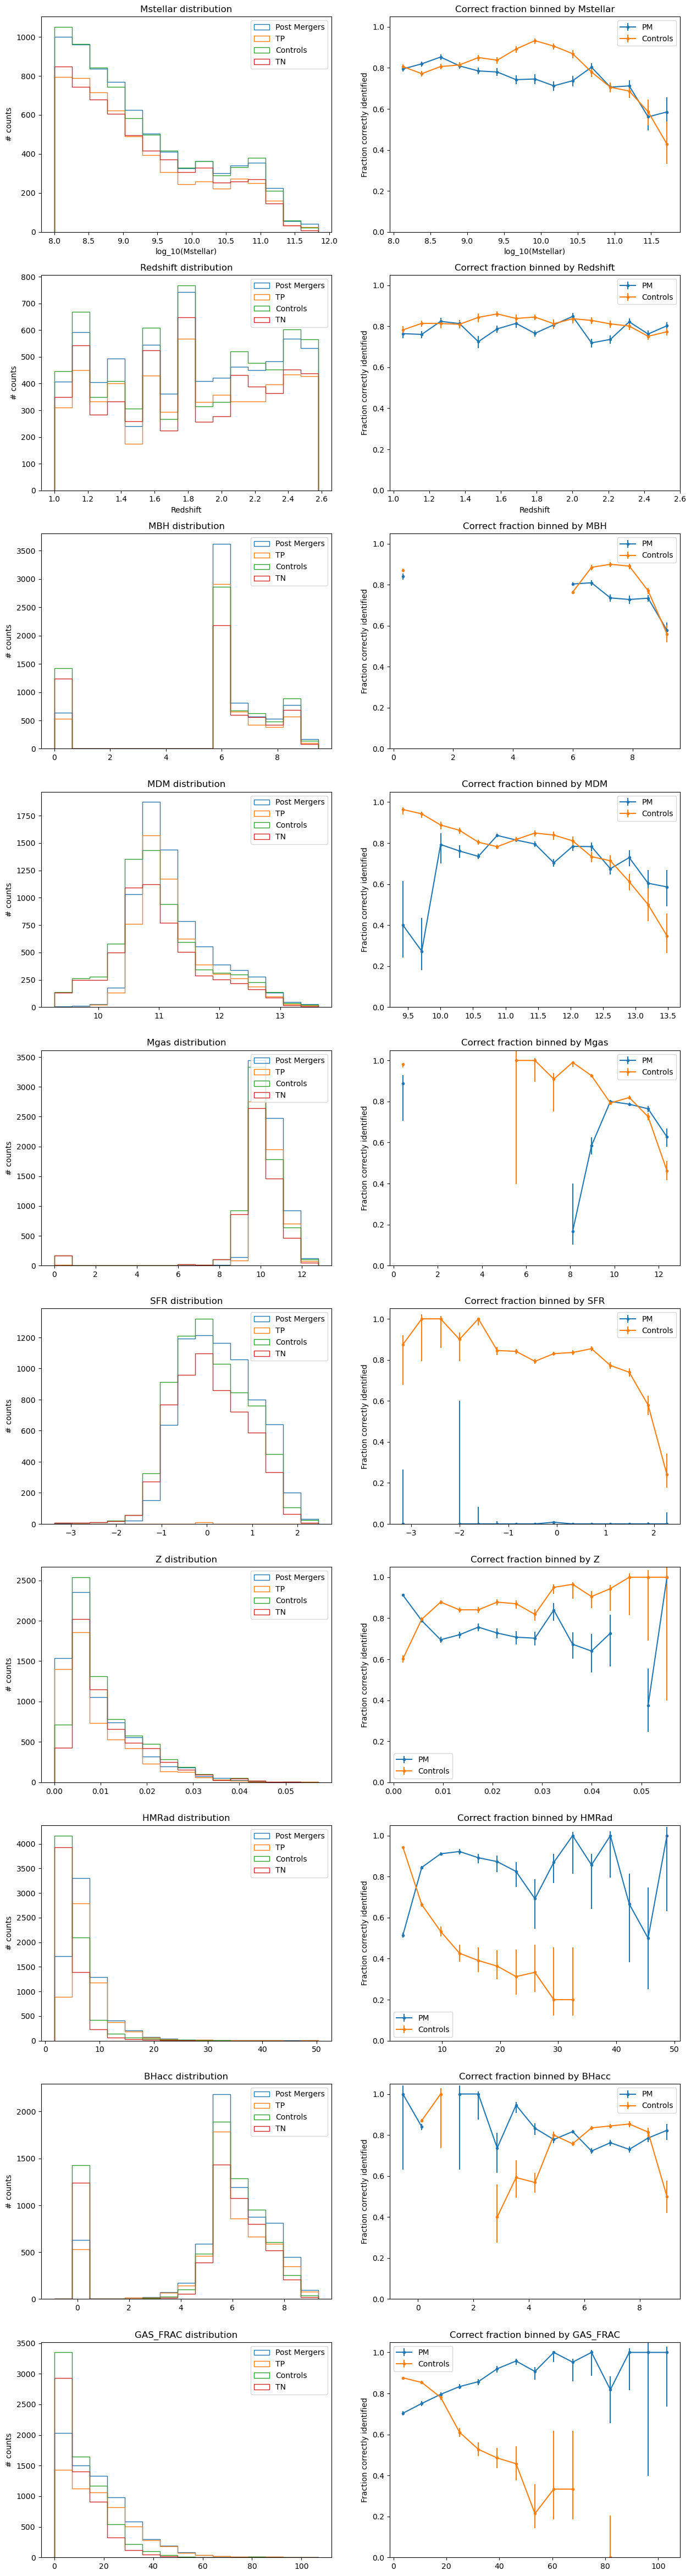

In [34]:
probs, centers = plot_split_results(results, TP, TN, params, no_log)

(15,)
1.0
0.01827740911551717
0 0
8.006120871236599 8.261914633050914
1 0
8.773502156679545 9.029295918493862
2 0
9.540883442122492 9.796677203936808
3 0
10.308264727565438 10.564058489379754
4 0
10.819852251194071 11.075646013008384
5 0
11.331439774822702 11.587233536637017
1.1053333333333333
0 1
10.0 10.043493267158574
1 1
10.119255889277937 10.152695941298854
2 1
10.212720154417843 10.239883152320884
3 1
10.289588952542596 10.312459457444763
4 1
10.334185585361674 10.354876422516234
5 1
10.374626164413602 10.393516708491143


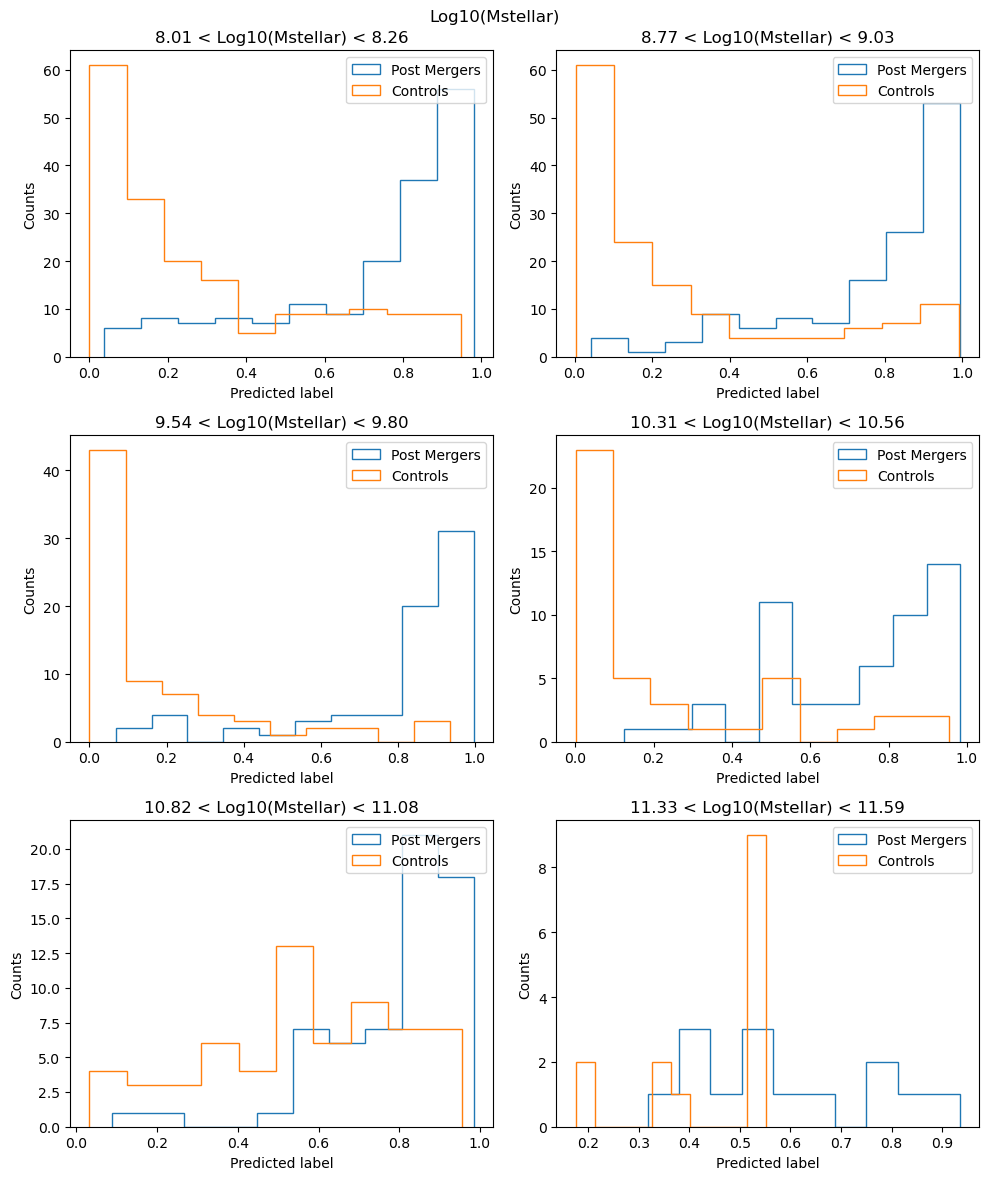

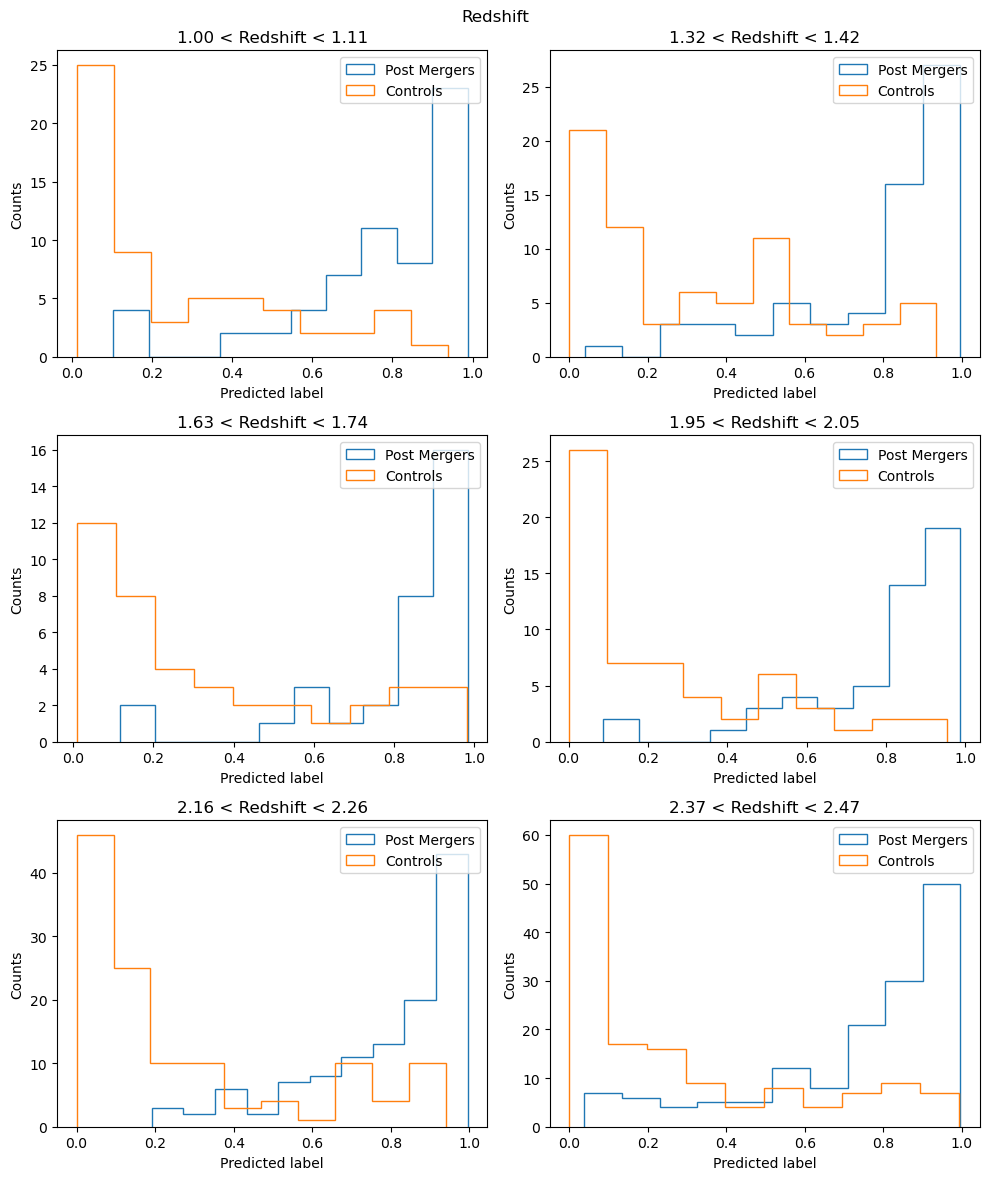

In [167]:
print(probs[0,1].shape)
print(probs[j,4][0][0])

bins = [0, 3, 6, 9, 11, 13]

params = ['Log10(Mstellar)', 'Redshift']

for j in range(len(params)):
    
    fig = plt.figure(figsize = (10, 2* int(len(bins))))
    ax = fig.subplots(int(len(bins)/2), 2)
    edges = np.array(probs[j,4])
    
    print(edges[0][1])
    
    for i in range(len(bins)):
        print(i, j)
        
        #ax[int(i/2), int(i%2)].hist(np.append(probs[j,0,bins[i]], probs[j,2,bins[i]]), histtype = 'step')
        ax[int(i/2), int(i%2)].hist(probs[j,0,bins[i]], histtype = 'step', label = 'Post Mergers')
        ax[int(i/2), int(i%2)].hist(probs[j,2,bins[i]], histtype = 'step', label = 'Controls')
        
        
        ax[int(i/2), int(i%2)].legend()
        ax[int(i/2), int(i%2)].set_xlabel('Predicted label')
        ax[int(i/2), int(i%2)].set_ylabel('Counts')
        
        if params[j] not in no_log:
            bin_min = np.log10(edges[bins[i]][0] * 1e10)
            bin_max = np.log10(edges[bins[i]][1] * 1e10)
        else:
            bin_min = edges[bins[i]][0]
            bin_max = edges[bins[i]][1]
        
        ax[int(i/2), int(i%2)].set_title('%.2f < %s < %.2f' % (bin_min, params[j], bin_max))
        
        print(np.log10(edges[bins[i]][0] * 1e10), np.log10(edges[bins[i]][1] * 1e10))
        
    fig.suptitle(params[j])
    fig.tight_layout()



In [15]:
results

,SFID,SnapNum,Mstellar,MBH,MDM,Mgas,SFR,Z,HMRad,BHacc,...,SFID_recent,snap_recent,ratio_biggest,dt_biggest,SFID_biggest,snap_biggest,Redshift,GAS_FRAC,PRED_LABEL,LABEL
0,376808.0,43.0,0.060560,0.000160,14.598457,2.062304,0.781217,0.003755,7.041241,0.000022,...,376808.0,43.0,0.315066,0.914,376715.0,37.0,1.30,[34.05382677175623],0.958378,1.0
1,430255.0,31.0,0.025230,0.000148,3.338307,0.391981,0.264703,0.007142,4.037092,0.000060,...,0.0,0.0,0.000000,0.000,0.0,0.0,2.21,[15.536155806970585],0.123981,0.0
2,14894.0,44.0,22.788361,0.102412,239.308029,6.698267,13.771405,0.023283,8.815554,0.000415,...,0.0,0.0,0.000000,0.000,0.0,0.0,1.25,[0.29393369281225185],0.552291,0.0
3,72886.0,31.0,4.919187,0.012897,111.198540,17.833580,57.104038,0.031479,5.948026,0.036438,...,72886.0,31.0,0.370903,0.000,72886.0,31.0,2.21,[3.625310395226653],0.982744,1.0
4,358972.0,38.0,0.153068,0.000173,10.072051,1.741873,2.295779,0.008993,4.793128,0.000087,...,300307.0,33.0,0.010381,0.753,300307.0,33.0,1.60,[11.379712849276437],0.019260,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2554,38838.0,31.0,7.533486,0.031367,275.384308,35.644176,155.602066,0.018792,4.572285,0.067868,...,38838.0,31.0,0.461014,0.836,39803.0,25.0,2.21,[4.731431736936056],0.984948,1.0
2555,292751.0,45.0,0.387525,0.001301,38.106148,6.440798,4.630165,0.010929,5.025292,0.000664,...,0.0,0.0,0.000000,0.000,0.0,0.0,1.21,[16.62035964007845],0.431068,0.0
2556,223119.0,42.0,2.852352,0.011939,80.843353,11.344776,9.385791,0.038638,5.727008,0.007633,...,223119.0,42.0,0.302481,0.000,223119.0,42.0,1.36,[3.9773413253335317],0.950140,1.0
2557,276796.0,34.0,0.158616,0.000234,16.931177,2.239113,3.083119,0.009002,4.951377,0.000412,...,276796.0,34.0,0.037685,0.000,276796.0,34.0,1.90,[14.116531571132162],0.815979,0.0


In [28]:
results.loc[(results['Mgas'] >100) & (results['Mgas'] < 1e4)]

,SFID,SnapNum,Mstellar,MBH,MDM,Mgas,SFR,Z,HMRad,BHacc,...,SFID_recent,snap_recent,ratio_biggest,dt_biggest,SFID_biggest,snap_biggest,Redshift,GAS_FRAC,PRED_LABEL,LABEL
14,14099.0,38.0,39.878448,0.117786,2212.977051,281.864471,69.007767,0.009375,8.764400,0.005211,...,0.0,0.0,0.000000,0.000,0.0,0.0,1.60,7.068090,0.513845,0.0
17,8492.0,43.0,50.760540,0.176392,3189.184814,457.288544,119.243713,0.015771,27.754585,0.000730,...,8492.0,43.0,0.136266,0.000,8492.0,43.0,1.30,9.008741,0.675477,1.0
51,17121.0,36.0,17.578279,0.054122,1001.813660,129.002167,38.423603,0.015522,12.244317,0.002253,...,17121.0,36.0,0.103133,0.000,17121.0,36.0,1.74,7.338725,0.671412,1.0
154,41321.0,46.0,18.795649,0.058232,1283.419067,163.068237,59.423988,0.011884,19.804935,0.000229,...,0.0,0.0,0.000000,0.000,0.0,0.0,1.15,8.675851,0.638099,0.0
248,59167.0,50.0,19.931412,0.092539,1400.407471,139.594467,5.135779,0.010184,10.616355,0.002340,...,0.0,0.0,0.000000,0.000,0.0,0.0,1.00,7.003742,0.675477,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13700,52752.0,46.0,24.096954,0.106958,1000.712036,114.491402,28.670851,0.013553,15.264771,0.000073,...,44664.0,41.0,0.040974,0.787,44664.0,41.0,1.15,4.751281,0.397757,0.0
13734,7343.0,39.0,35.298000,0.060451,1763.166138,216.358109,202.747375,0.013883,21.768412,0.000632,...,0.0,0.0,0.000000,0.000,0.0,0.0,1.53,6.129472,0.640616,0.0
13887,31452.0,50.0,45.840069,0.182512,2790.629639,409.721039,8.551728,0.008462,28.187551,0.000464,...,0.0,0.0,0.000000,0.000,0.0,0.0,1.00,8.938055,0.665529,0.0
14015,26197.0,41.0,30.882215,0.141811,1410.936035,157.860550,16.073681,0.014151,29.423120,0.000863,...,26197.0,41.0,0.177989,0.296,24433.0,39.0,1.41,5.111698,0.527164,1.0


In [15]:
params = ['Mstellar', 'Redshift', 'HMRad']

#params = ['Mstellar', 'Redshift', 'MBH', 'MDM', 'Mgas', 'SFR', 'Z',
#       'HMRad', 'BHacc', 'GAS_FRAC']

no_log = ['Redshift', 'ratio_recent', 'Z', 'ratio_recent', 'dt_recent', 'ratio_biggest', 'dt_biggest','GAS_FRAC']

scale = {'Mstellar': 1e10, 'MDM': 1e10, 'Mgas': 1e10, 'HMRad': 1, 'MBH': 1e10, 'BHacc' : 1e10, 'SFR' : 1, 'HMRad' : 1}
xlabels = {'Mstellar' : 'log_10(Mstellar)', 'Redshift' : 'Redshift', 'HMRad' : 'log_10(Half Mass Radius [kpc])'}

def plot_multi_results(results_list, params, no_log):
    

    for param in params:
        
        fig = plt.figure(figsize = (15,6 * len(results_list)))
        ax = fig.subplots(len(results_list),2)
        
        probs = []
        
        for i, results in enumerate(results_list):
            
            
            error_bars = []

            if param in no_log:
                counts_M_total, edges_M, bars = ax[i,0].hist(results.loc[results['LABEL'] == 1][param].values, bins = 15, histtype = 'step', label = 'Post Mergers')
                counts_M, edges, bars = ax[i,0].hist(results.loc[(results['LABEL'] == 1) & (results['PRED_LABEL'] > 0.5)][param].values, bins = edges_M, histtype = 'step', label = 'TP')
                counts_NM_total, edges_NM, bars = ax[i,0].hist(results.loc[results['LABEL'] == 0][param].values, bins = edges_M, histtype = 'step', label = 'Controls')
                counts_NM, edges, bars = ax[i,0].hist(results.loc[(results['LABEL'] == 0) & (results['PRED_LABEL'] < 0.5)][param].values, bins = edges_M, histtype = 'step', label = 'TN')

            else:
                # Create variable with log(results) and set -inf = 0

                results_M_total = np.log10(results.loc[results['LABEL'] == 1][param].values * scale[param])
                results_M = np.log10(results.loc[(results['LABEL'] == 1) & (results['PRED_LABEL'] > 0.5)][param].values * scale[param])
                results_NM_total = np.log10(results.loc[results['LABEL'] == 0][param].values * scale[param])
                results_NM = np.log10(results.loc[(results['LABEL'] == 0) & (results['PRED_LABEL'] < 0.5)][param].values * scale[param])

                
                results_M_total[results_M_total == -np.inf] = 0
                results_M[results_M == -np.inf] = 0
                results_NM_total[results_NM_total == -np.inf] = 0
                results_NM[results_NM == -np.inf] = 0
                

                counts_M_total, edges_M, bars = ax[i,0].hist(results_M_total, bins = 15, histtype = 'step', label = 'Post Mergers')
                counts_M, edges, bars = ax[i,0].hist(results_M, bins = edges_M, histtype = 'step', label = 'TP')
                counts_NM_total, edges_NM, bars = ax[i,0].hist(results_NM_total, bins = edges_M, histtype = 'step', label = 'Controls')
                counts_NM, edges, bars = ax[i,0].hist(results_NM, bins = edges_M, histtype = 'step', label = 'TN')
                
                
                #counts_M_total, edges_M, bars = ax[i,0].hist(np.log10(results.loc[results['LABEL'] == 1][params[i]].values * 1e10), bins = 15, histtype = 'step', label = 'Post Mergers')
                #counts_M, edges, bars = ax[i,0].hist(np.log10(TP[params[i]].values * 1e10), bins = edges_M, histtype = 'step', label = 'TP')
                #counts_NM_total, edges_NM, bars = ax[i,0].hist(np.log10(results.loc[results['LABEL'] == 0][params[i]].values * 1e10), bins = 15, histtype = 'step', label = 'Controls')
                #counts_NM, edges, bars = ax[i,0].hist(np.log10(results.loc[(results['LABEL'] == 0) & (results['PRED_LABEL'] < 0.5)][params[i]].values * 1e10), bins = edges_NM, histtype = 'step', label = 'TN')

            if param not in no_log:
                edges_M = 10**(edges_M-10)

            c = 0.683
            k_M, k_NM = counts_M, counts_NM
            n_M, n_NM = counts_M_total, counts_NM_total
            p_M_lower, p_NM_lower = dist.beta.ppf((1-c)/2.,k_M+1,n_M-k_M+1), dist.beta.ppf((1-c)/2.,k_NM+1,n_NM-k_NM+1)
            p_M_upper, p_NM_upper = dist.beta.ppf(1-(1-c)/2.,k_M+1,n_M-k_M+1), dist.beta.ppf(1-(1-c)/2.,k_NM+1,n_NM-k_NM+1)



            probs_M_total = []
            probs_M = []
            probs_NM_total = []
            probs_NM = []
            bin_edges = []

            for j in range(len(edges_M) - 1):
                probs_M_total.append(results.loc[(results['LABEL'] == 1) & (results[param] > edges_M[j]) & (results[param] < edges_M[j + 1])]['PRED_LABEL'].values)
                probs_M.append(results.loc[(results['LABEL'] == 1) & (results['PRED_LABEL'] > 0.5)].loc[(results[param] > edges_M[j]) & (results[param] < edges_M[j + 1])]['PRED_LABEL'].values)
                probs_NM_total.append(results.loc[(results['LABEL'] == 0) & (results[param] > edges_M[j]) & (results[param] < edges_M[j + 1])]['PRED_LABEL'].values)
                probs_NM.append(results.loc[(results['LABEL'] == 0) & (results['PRED_LABEL'] < 0.5)].loc[(results[param] > edges_M[j]) & (results[param] < edges_M[j + 1])]['PRED_LABEL'].values)
                bin_edges.append(np.array([edges_M[j], edges_M[j + 1]]))

            
            
            ax[i,0].set_title(param + ' distribution')
            ax[i,0].set_ylabel('# counts')
            ax[i,0].set_xlabel(xlabels[param])
            ax[i,0].legend()
            
            probs.append([probs_M_total, probs_M, probs_NM_total, probs_NM, bin_edges])


            centers = 0.5*(edges[1:]+ edges[:-1])
            
            yerr_low = p_M_lower - counts_M/counts_M_total
            yerr_up = p_M_upper - counts_M/counts_M_total 
            yerr_low[yerr_low > 0] = 0
            yerr_up[yerr_up < 0] = 0
            
            yerr = np.absolute(np.array([yerr_low, yerr_up]))
            ax[i,1].errorbar(centers, counts_M/counts_M_total, yerr = yerr, fmt = '.-', label = 'PM')

            yerr_low = p_NM_lower - counts_NM/counts_NM_total
            yerr_up = p_NM_upper - counts_NM/counts_NM_total 
            yerr_low[yerr_low > 0] = 0
            yerr_up[yerr_up < 0] = 0
            yerr = np.absolute(np.array([yerr_low, yerr_up]))

            ax[i,1].errorbar(centers, counts_NM/counts_NM_total, yerr = yerr , fmt = '.-', label = 'Controls')
            
            ax[i,1].set_ylabel('Fraction correctly identified')
            ax[i,1].set_title('Correct fraction binned by ' + param)
            ax[i,1].set_ylim(0, 1.05)
            ax[i,1].legend()


        #plt.hist(np.log10(false.Mstellar.values), histtype = 'step', density = True)
        plt.tight_layout()

    return np.array(probs), centers

/opt/anaconda3/envs/astroconda3/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/envs/astroconda3/lib/python3.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/envs/astroconda3/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/envs/astroconda3/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/envs/astroconda3/lib/python3.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/envs/astroconda3/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/envs/astroconda3/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: invalid value encountered in true

(array([[[array([], dtype=float64), array([], dtype=float64),
          array([], dtype=float64), array([], dtype=float64),
          array([], dtype=float64), array([], dtype=float64),
          array([], dtype=float64), array([], dtype=float64),
          array([], dtype=float64), array([], dtype=float64),
          array([], dtype=float64), array([], dtype=float64),
          array([], dtype=float64), array([], dtype=float64),
          array([], dtype=float64)],
         [array([], dtype=float64), array([], dtype=float64),
          array([], dtype=float64), array([], dtype=float64),
          array([], dtype=float64), array([], dtype=float64),
          array([], dtype=float64), array([], dtype=float64),
          array([], dtype=float64), array([], dtype=float64),
          array([], dtype=float64), array([], dtype=float64),
          array([], dtype=float64), array([], dtype=float64),
          array([], dtype=float64)],
         [array([], dtype=float64), array([], dtype=float6

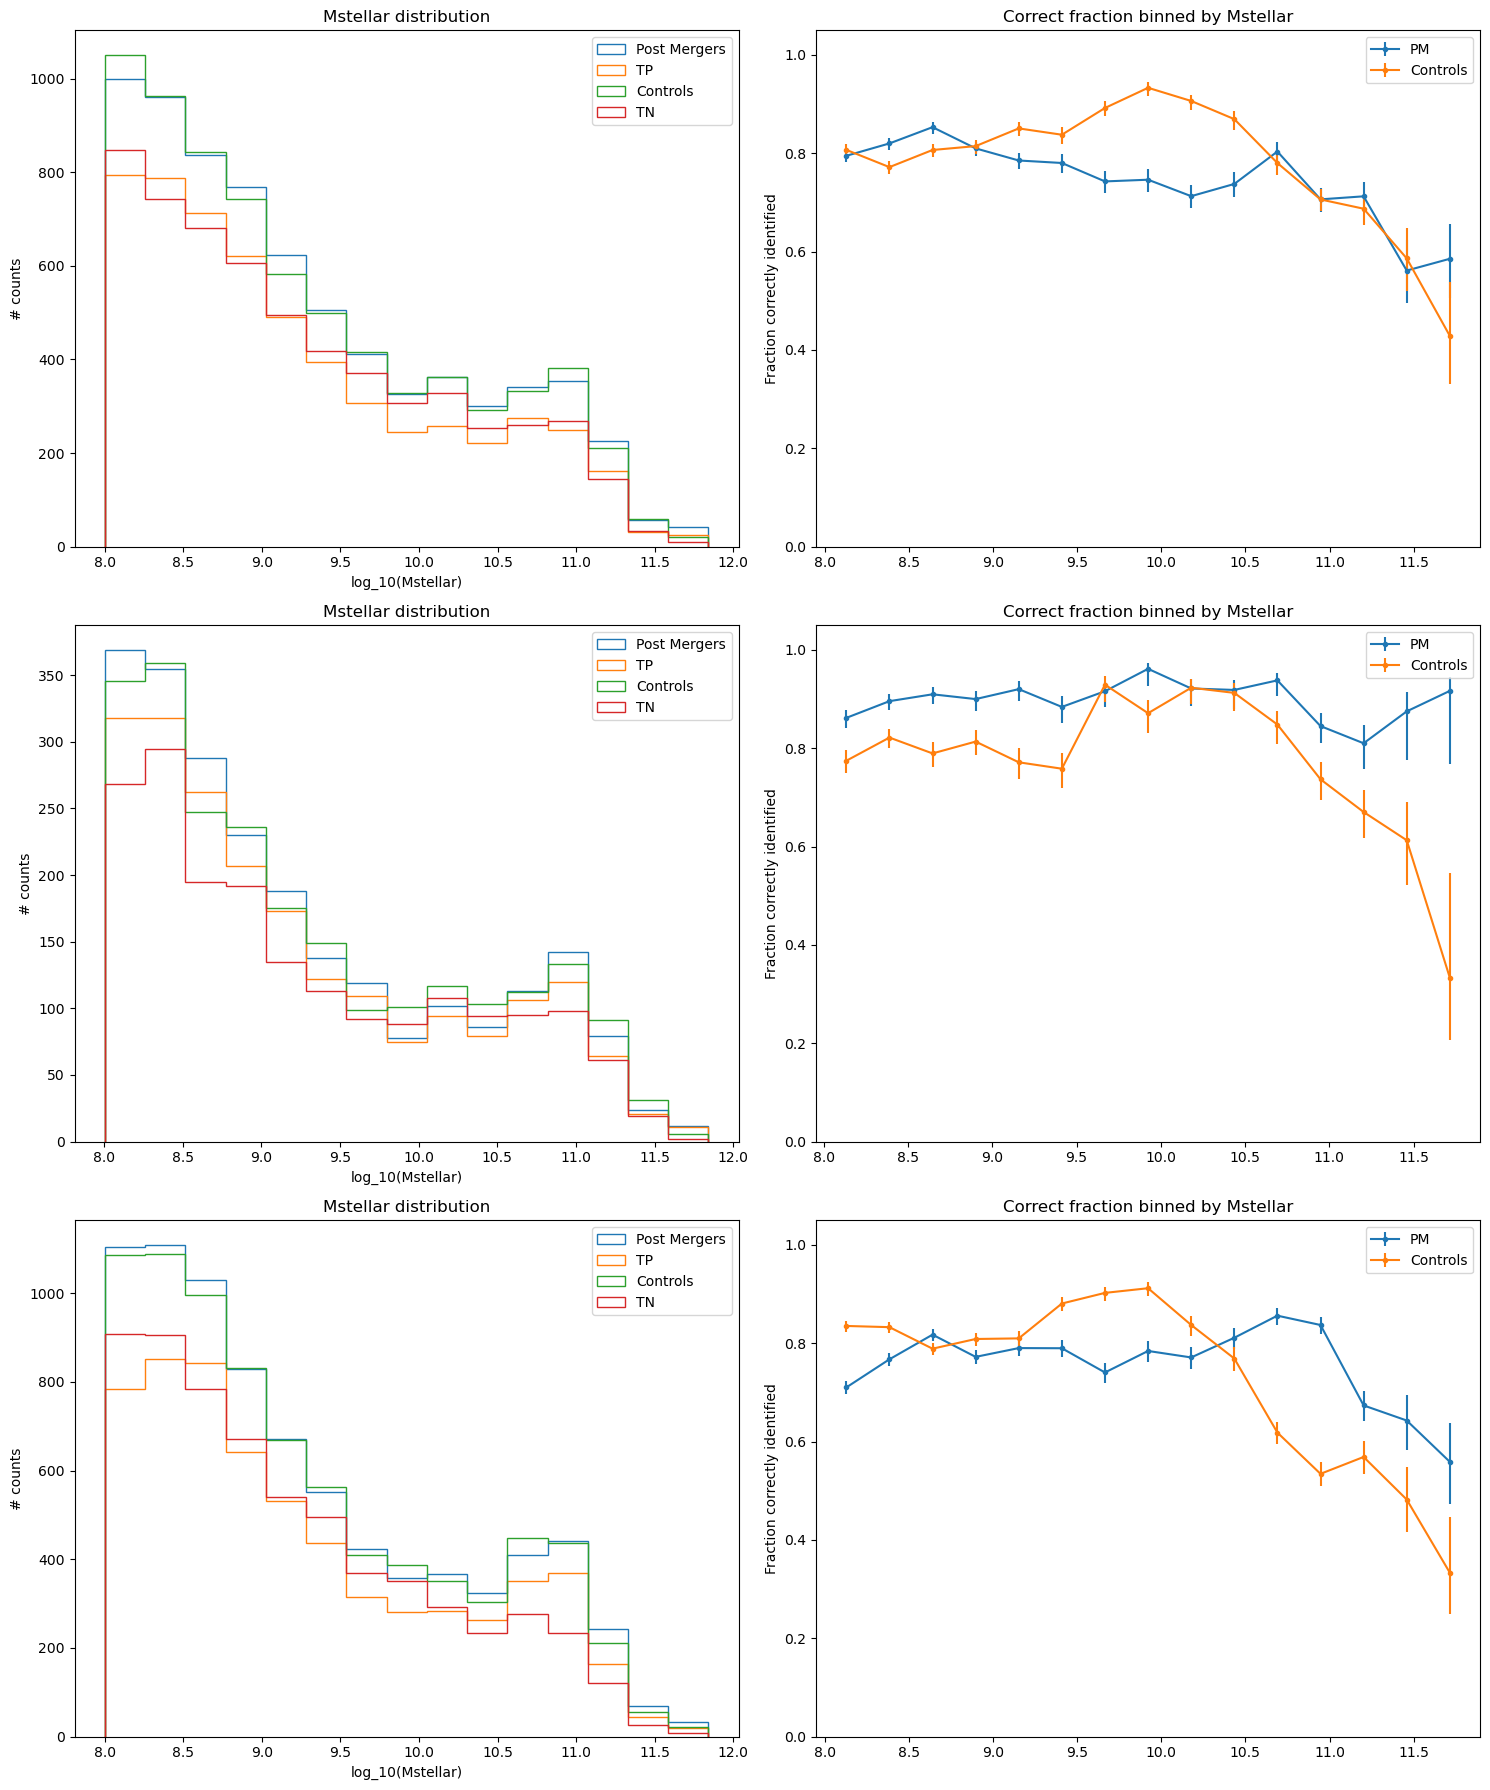

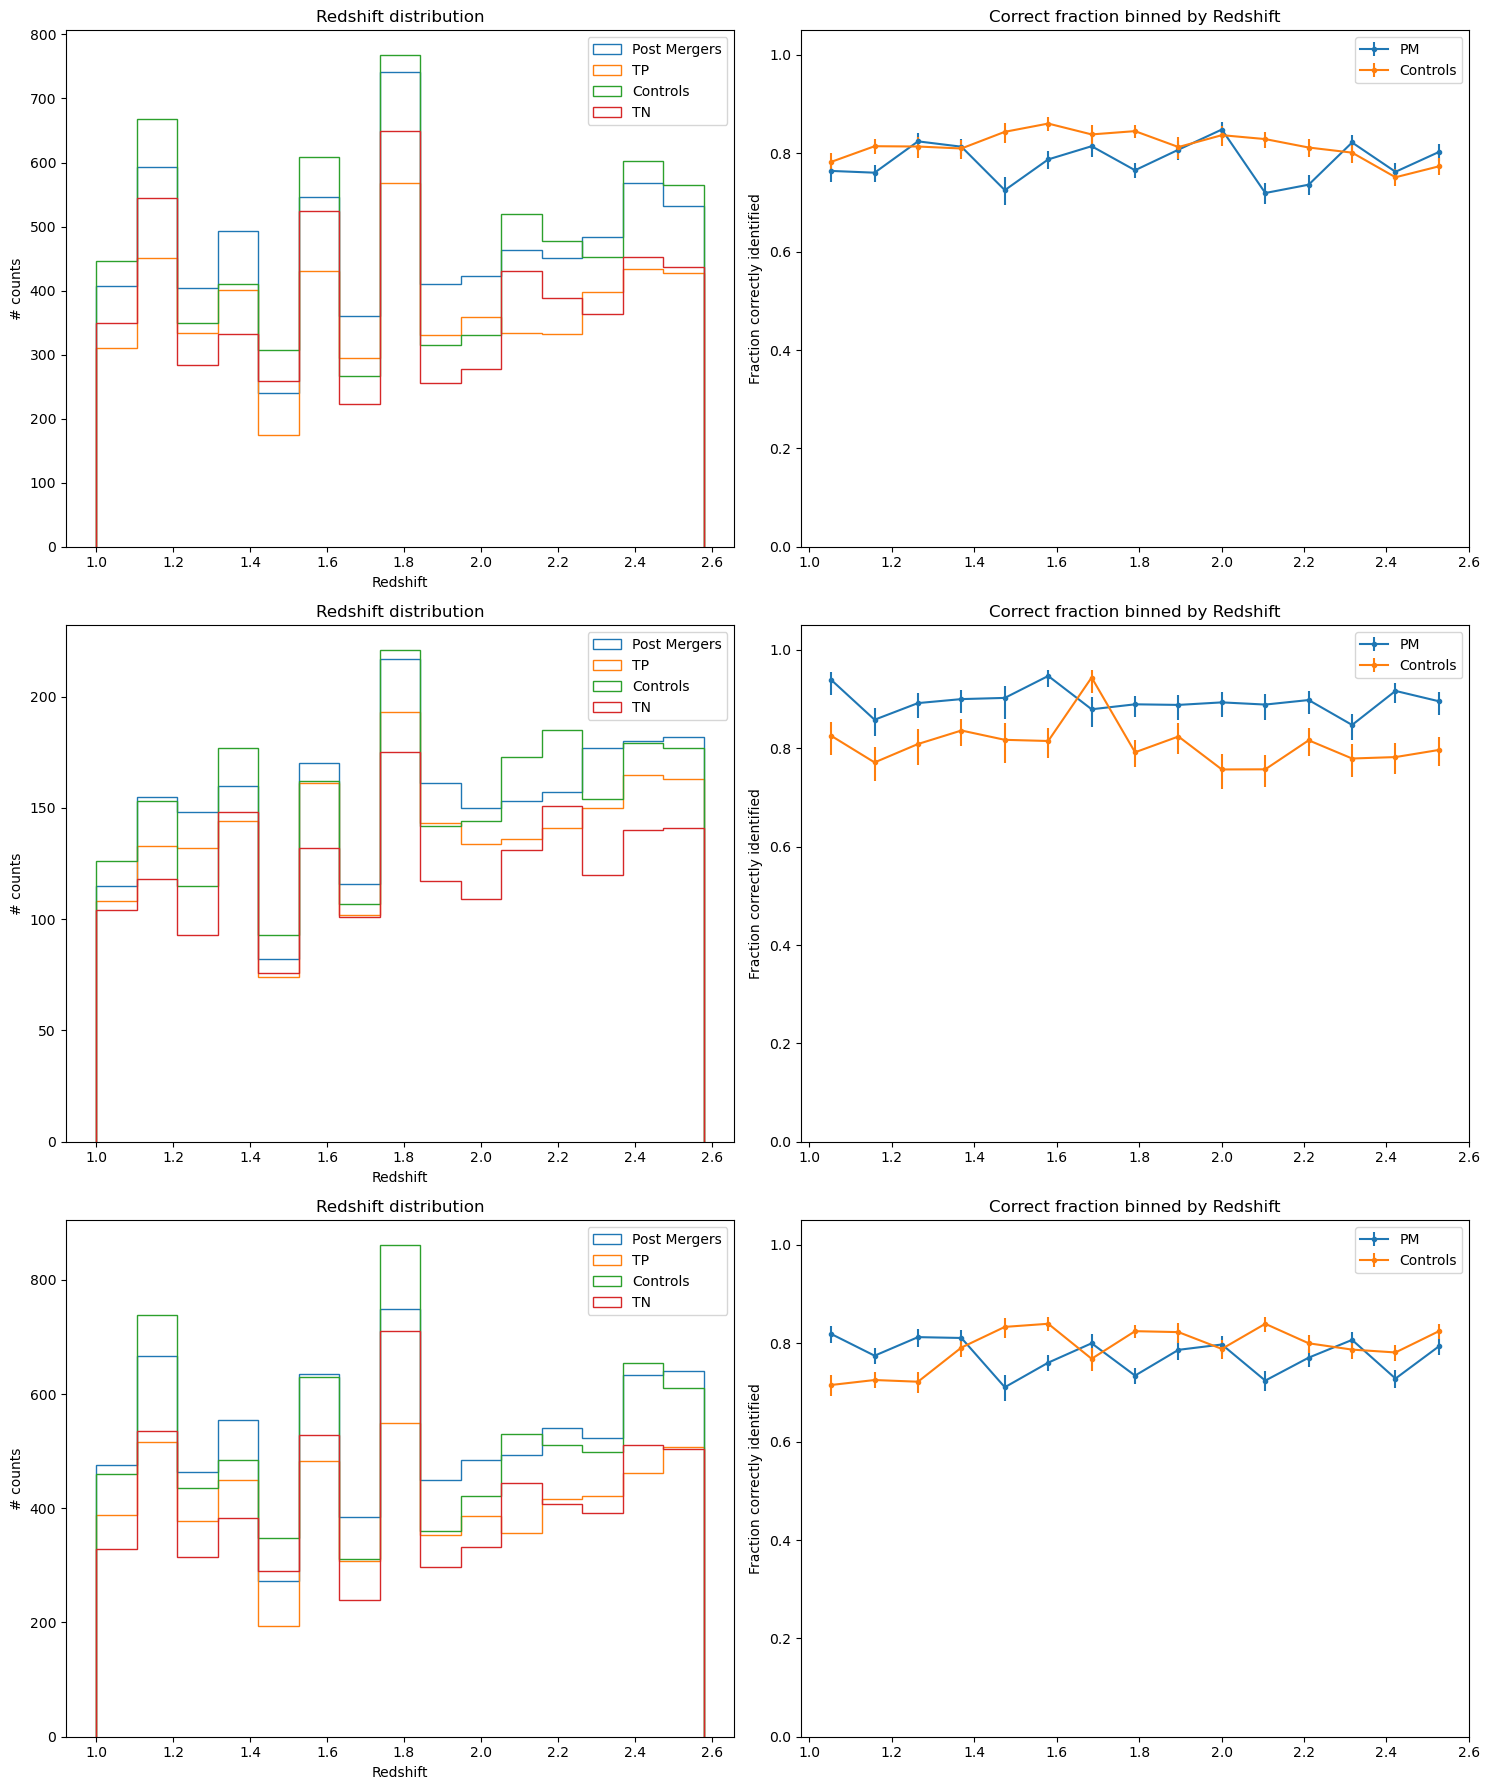

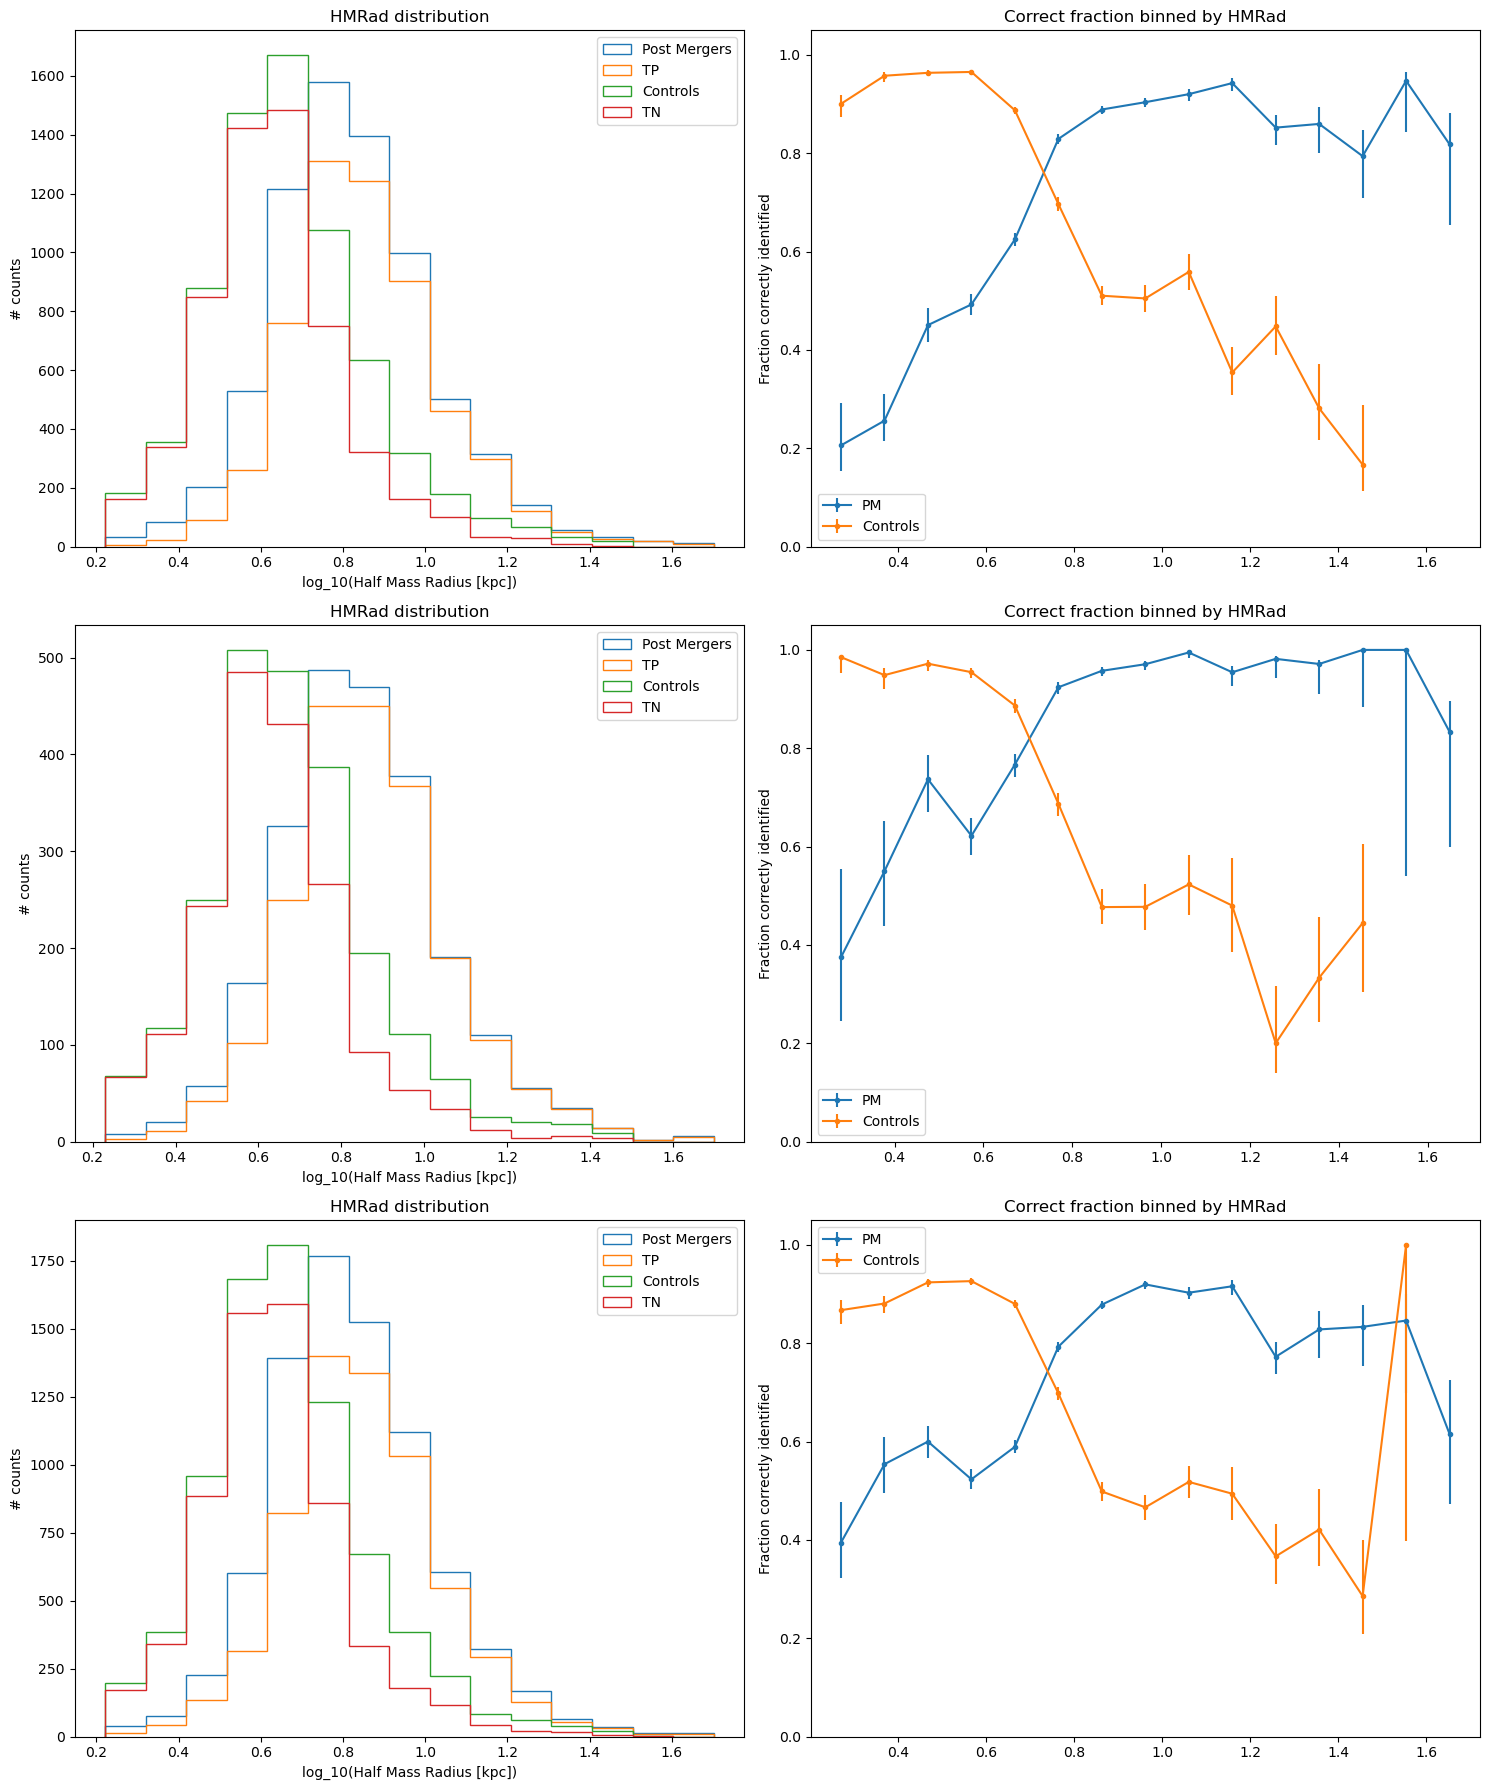

In [16]:
results_list = [results_14, results_4, results_15]
plot_multi_results(results_list, params, no_log)

In [158]:
# Plot a few example galaxies from each population

fig = plt.figure(figsize = (10,20))
ax = fig.subplots(4,3)

conditions = d
for condition in conditions:
    
    for i in range(3):
        idx = np.random.randint(0, len(dfs[df]))
        hdul = fits.open(real_dir + 'SFID_%07d_SNAP_%02d.fits' %(dfs[df]['SFID'][idx], dfs[df]['SnapNum'][idx]))
        ax[df,i].imshow(hdul[1].data[0])
        ax[df,i].set_title('Label = %01d, Pred Label = %.02f' %(dfs[df]['LABEL'][idx], dfs[df]['PRED_LABEL'][idx]))

[           SFID  SnapNum  Mstellar       MBH         MDM       Mgas  \
 0      326268.0     49.0  0.014933  0.000000    1.896915   0.168298   
 1      501028.0     44.0  0.018324  0.000107    5.155341   0.529885   
 2      401693.0     40.0  0.012923  0.000000    0.573321   0.063965   
 3       32175.0     35.0  9.181404  0.092052  539.761230  59.148537   
 4      126033.0     44.0  6.076739  0.017329  267.684906  37.030781   
 ...         ...      ...       ...       ...         ...        ...   
 14198  322996.0     33.0  0.072874  0.000085    9.319251   1.283821   
 14199  343178.0     29.0  0.015874  0.000142    5.600752   0.487539   
 14200    6575.0     29.0  6.178263  0.026965   84.567413   6.747950   
 14201       4.0     35.0  7.390371  0.047765    7.991107   0.028567   
 14202  296927.0     28.0  0.071279  0.000110    6.656391   0.583155   
 
              SFR         Z      HMRad     BHacc  ...  SFID_recent  \
 0       0.088420  0.004609   2.947429  0.000000  ...          0

In [21]:
results_4.loc[results_4['Mstellar'] > 100]

,SFID,SnapNum,Mstellar,MBH,MDM,Mgas,SFR,Z,HMRad,BHacc,...,SFID_recent,snap_recent,ratio_biggest,dt_biggest,SFID_biggest,snap_biggest,Redshift,GAS_FRAC,PRED_LABEL,LABEL


2274
608


TypeError: Invalid shape (3, 105, 105) for image data

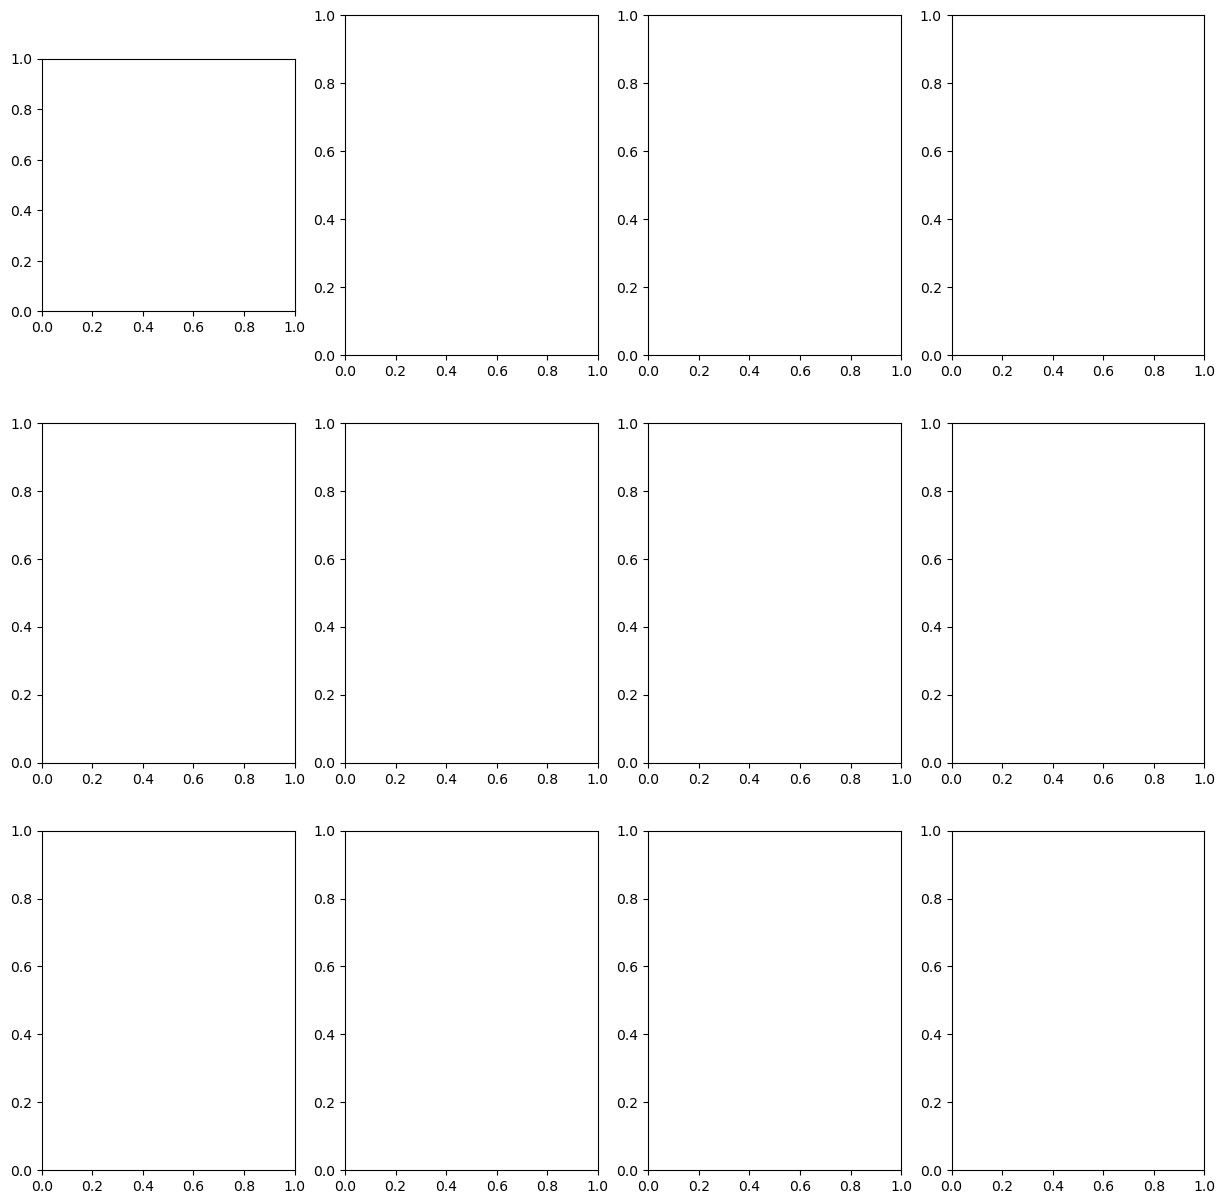

In [23]:
# Plot a few example galaxies from each population

dfs = [TP, FP, TN, FN]

mass_lims_list = [[5, 10], [20, 25], [25, 45], [45, 75]]
hm_rad_lims = [[6.3, 10], [10, 16], [16, 25]]

fig = plt.figure(figsize = (15,5 * len(hm_rad_lims)))
ax = fig.subplots(len(hm_rad_lims),4)

for j, hm_rad_lims in enumerate(hm_rad_lims):

    for i, df in enumerate(dfs):
        df_filt = df.loc[(df['HMRad'] > hm_rad_lims[0]) & (df['HMRad'] < hm_rad_lims[1])].reset_index(drop = True)
        print(len(df_filt))
        if (len(df_filt) > 0):
            idx = np.random.randint(0, len(df_filt))
            print(idx)
            hdul = fits.open(real_dir + 'SFID_%07d_SNAP_%02d.fits' %(df_filt['SFID'][idx], df_filt['SnapNum'][idx]))
            ax[j,i].imshow(hdul[1].data, cmap = 'gray_r')
            ax[j,i].set_title('Label = %01d, Pred Label = %.02f' %(df_filt['LABEL'][idx], df_filt['PRED_LABEL'][idx]))
            ax[j,i].set_xlabel('Half mass radius = %.2f'%(df_filt['HMRad'][idx] / 0.7) + ' kpc')